# Athlete Dashboard - Preparation
Development sandbox for the athlete dashboard user interface.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import panel as pn
import panel.widgets as pnw
import panel.pane as pnp
import param

# constants
ALL_EVENTS_NAME = 'All'
EVENT_500M = '500m'
EVENT_1000M = '1000m'
EVENT_1500M = '1500m'
DEFAULT_START_POSITION = 1
DEFAULT_POSITION_CHANGE = 1

In [2]:
full_rounds = pd.read_csv('../data/scraped/cleaned/rounds_splits.csv')

# replace 0 positions and laptimes with NaN
pos_cols = [f'lap_{x}_position' for x in range(1, 46)]
laptime_cols = [f'lap_{x}_laptime' for x in range(1, 46)]
full_rounds[pos_cols] = full_rounds[pos_cols].replace(0.0, np.nan)
full_rounds[laptime_cols] = full_rounds[laptime_cols].replace(0.0, np.nan)

laptimes = pd.read_csv('../data/scraped/cleaned/individual_athlete_lap_data.csv')

C:\Users\ahale\Anaconda3\envs\shorttrack\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (15,19,20,22,23,25,26,28,29,31,34,37,40,43,46,47,49,50,52,53,55,56,58,59,62,65,68,71,74,77,80,83,86,89,92,95,98,101,104,107,109,110,113,116,119,122,125,128,131,134,137,140,143,146,149,151,152) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\ahale\Anaconda3\envs\shorttrack\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (6,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
individual_events = full_rounds[full_rounds['event'].isin({'500m', '1000m', '1500m'})]

Launching server at http://localhost:65190


<ipython-input-7-f3df2f6ed974>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  athlete_races_500m['lap_1_laptime'] = athlete_races_500m['lap_1_laptime'].astype('float')


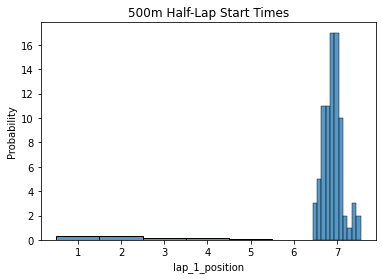

In [7]:
# helper functions
def select_event_subset(df, e):
    """
    Return only the rows of df which belong to the requested event.
    """
    return df[df['event'] == e]


# declare UI template
ui_template = pn.template.MaterialTemplate(title='Short Track Athlete Profile')
pn.config.sizing_mode = 'stretch_width'

# declare variable widgets
athlete_name = pnw.Select(name='Athlete', options=list(individual_events['Name'].unique()))
event_distance = pnw.RadioButtonGroup(name='Event', value=ALL_EVENTS_NAME)
start_position = pnw.RadioButtonGroup(name='Start Position')
position_gain_loss = pnw.RadioButtonGroup(name='Position Gain/Loss')
athlete_races = pnw.DataFrame()
athlete_races_single_event = pnw.DataFrame()
athlete_laptimes = pnw.DataFrame()
athlete_laptimes_single_event = pnw.DataFrame()


def athlete_name_changed(event):
    """
    Triggering event is athlete_name.value
    """
    athlete_races.value = individual_events[individual_events['Name'] == event.new]
    athlete_laptimes.value = laptimes[laptimes['Name'] == event.new]

    event_distance.options = list(athlete_races.value['event'].unique()) + [ALL_EVENTS_NAME]
    if event_distance.value not in event_distance.options:
        # if the new event distance options don't contain the current event_distance value, default to ALL_EVENTS_NAME
        event_distance.value = ALL_EVENTS_NAME
    else:
        # if there was no change, trigger the widget refresh manually
        event_distance.param.trigger('value')


def event_distance_changed(event):
    """
    Triggering event is event_distance.value
    """
    if event.new == ALL_EVENTS_NAME:
        athlete_races_single_event.value = athlete_races.value
        athlete_laptimes_single_event.value = athlete_laptimes.value
    else:
        athlete_races_single_event.value = athlete_races.value[athlete_races.value['event'] == event.new]
        athlete_laptimes_single_event.value = athlete_laptimes.value[athlete_laptimes.value['event'] == event.new]

    start_position.options = list(athlete_races.value['Start Pos.'].unique())
    position_gain_loss.options = list(athlete_laptimes.value['position_change'].unique())
    
    if start_position.value not in start_position.options:
        start_position.value = DEFAULT_START_POSITION
    if position_gain_loss.value not in position_gain_loss.options:
        position_gain_loss.value = DEFAULT_POSITION_CHANGE
        


# declare reloading between widgets
athlete_name.param.watch(athlete_name_changed, 'value')
event_distance.param.watch(event_distance_changed, 'value')

# trigger initial widget dependencies
athlete_name.param.trigger('value')


@pn.depends(athlete_races_single_event)
def first_lap_positions(athlete_races_single_event__):
    """
    The position in the pack that the athlete likes to start this event distance.
    """
    return sns.histplot(data=athlete_races_single_event__,
                        x="lap_1_position",
                        stat="probability",
                        discrete=True).set_title(f'Early Selection of Position in Pack - {event_distance.value}')


@pn.depends(athlete_races)
def half_lap_500m(athlete_races__):
    """
    The athlete's average 500m half-lap start time, and a histogram of the athlete's 500m half-lap start time
    """
    athlete_races_500m = select_event_subset(athlete_races__, EVENT_500M)
    athlete_races_500m['lap_1_laptime'] = athlete_races_500m['lap_1_laptime'].astype('float')

    mean_start_time = round(athlete_races_500m['lap_1_laptime'].astype('float').mean(), 3)
    mean_start_indicator = pn.indicators.Number(name='Mean 500m Half-Lap Start Time', value=mean_start_time,
                                                format='{value}s')

    thresholded_start_times = athlete_races_500m[athlete_races_500m['lap_1_laptime'] < 9]
    plot = sns.histplot(data=thresholded_start_times,
                        x="lap_1_laptime").set_title('500m Half-Lap Start Times')

    return mean_start_indicator, plot


@pn.depends(start_position, athlete_races)
def start_performance_500m(start_position__, athlete_races__):
    """
    A histogram of the position the athlete is in after the first half-lap of the 500m, for the selected start position.
    """
    athlete_races_500m = athlete_races__[athlete_races__['event'] == EVENT_500M]
    start_performances = athlete_races_500m[athlete_races_500m['Start Pos.'] == int(start_position__)]
    start_performances['lap_1_position'] = start_performances['lap_1_position'].astype('float')

    return sns.histplot(data=start_performances,
                        x="lap_1_position").set_title(f'500m Start Result from Lane {start_position__}')


@pn.depends(athlete_laptimes)
def fastest_leading_laptimes(athlete_laptimes__):
    """
    The average of the 25 fastest laptimes achieved by the athlete when leading the race.
    """
    return pn.indicators.Number(name='Fastest Leading Laptimes',
                                value=round(athlete_laptimes__[athlete_laptimes__['lap_end_position'] == 1][
                                                'laptime'].nsmallest(25).mean(), 3),
                                format='{value}s')


@pn.depends(athlete_laptimes)
def fastest_following_laptimes(athlete_laptimes__):
    """
    The average of the 25 fastest laptimes achieved by the athlete when not leading the race.
    """
    return pn.indicators.Number(name='Fastest Leading Laptimes',
                                value=round(athlete_laptimes__[athlete_laptimes__['lap_end_position'] != 1][
                                                'laptime'].nsmallest(25).mean(), 3),
                                format='{value}s')


@pn.depends(athlete_laptimes_single_event, position_gain_loss)
def likely_lap_to_pass(athlete_laptimes_single_event__, position_gain_loss__):
    """
    A histogram of how often an athlete makes a pass (or gets passed) on a particular lap, for the selected number of
    positions gained/lost in the selected event distance.
    """
    selected_passes = athlete_laptimes_single_event__[
        athlete_laptimes_single_event__['position_change'] == position_gain_loss__]

    return sns.histplot(data=selected_passes,
                        x="lap").set_title(f'Passes on each Lap of {position_gain_loss__} Positions')


@pn.depends(athlete_races_single_event)
def x_plus_y_position_selection(athlete_races_single_event__):
    """
    A histogram displaying which advancing position an athlete selects, when there are multiple available.
    """
    advancing_races = athlete_races_single_event__[athlete_races_single_event__['Qual.'].isin(['Q', 'q', 'QA', 'qA'])]
    advancing_races['Place'] = advancing_races['Place'].astype('int')

    return sns.histplot(data=advancing_races,
                        x="Place").set_title('X + Y Position Selection')


@pn.depends(athlete_laptimes)
def pacing_1500m(athlete_laptimes__):
    """
    The average pace that the athlete likes to skate when leading the first 4 laps of the 1500m event.

    The amount that the athlete likes to pick up the pace when making a pass in the first 4 laps of the 1500m distance
    """
    laps = select_event_subset(athlete_laptimes__, EVENT_1500M)
    leading_pace = laps[(laps['lap'] > 1) &
                        (laps['lap'] < 5) &
                        (laps['lap_start_position'] == 1) &
                        (laps['position_change'] == 0)]['laptime'].mean()

    leading_pace_indicator = pn.indicators.Number(name='1500m Leading Pace',
                                                  value=round(leading_pace, 2),
                                                  format='{value}s')

    early_passes_to_front = laptimes[(laptimes['lap'] > 1) &
                                     (laptimes['lap'] < 5) &
                                     (laptimes['lap_start_position'] > 1) &
                                     (laptimes['lap_end_position'] == 1)]

    speed_up_sum = 0
    denominator = len(early_passes_to_front)

    for idx, early_pass in early_passes_to_front.iterrows():
        previous_laptime = laptimes[
            (laptimes['season'] == early_pass['season']) & (laptimes['competition'] == early_pass['competition']) & (
                    laptimes['event'] == early_pass['event']) & (laptimes['gender'] == early_pass['gender']) & (
                    laptimes['round'] == early_pass['round']) & (laptimes['race'] == early_pass['race']) & (
                    laptimes['instance_of_event_in_competition'] == early_pass[
                'instance_of_event_in_competition']) & (laptimes['lap'] == early_pass['lap'] - 1)]
        if len(previous_laptime):
            speed_up_sum += previous_laptime.iloc[0]['laptime'] - early_pass['laptime']
        else:
            denominator -= 1

    pace_instigation_indicator = pn.indicators.Number(name='1500m Pace Instigation',
                                                      value=round((speed_up_sum / denominator), 3),
                                                      format='{value}s')

    return leading_pace_indicator, pace_instigation_indicator


# set up sidebar display
ui_template.sidebar.append(athlete_name)
ui_template.sidebar.append(event_distance)
ui_template.sidebar.append(start_position)

# # set up main display
# ui_template.main.append(
#     pn.Column(pn.Row(first_lap_positions, half_lap_500m),
#               pn.Row(start_performance_500m, fastest_leading_laptimes, fastest_following_laptimes),
#               pn.Row(likely_lap_to_pass, x_plus_y_position_selection),
#               pn.Row(pacing_1500m))
# )

# set up main display
ui_template.main.append(
    pn.Column(pn.Row(first_lap_positions, half_lap_500m))
)

# launch display
ui_template.show()

In [ ]:
# import os
# output_filepath = 'backup_laptimes.csv'

# race_details_cols = list(individual_events.columns[:16]) + ['instance_of_event_in_competition']
# lap_details_cols = race_details_cols.copy()
# lap_details_cols.extend(['lap', 'laptime', 'lap_start_position', 'lap_end_position', 'position_change'])


# for index, athlete_race in tqdm(individual_events.iterrows()):
#     laptimes = pd.DataFrame(columns=lap_details_cols)
#     start_lap = 2 if athlete_race['event'] in ['500m', '1500m'] else 1
#     for i in range(start_lap, 46):
#         try:
#             laptime = float(athlete_race[f'lap_{i}_laptime'])
#         except Exception:
#             laptime = np.nan
        
#         # TODO use standard deviation to filter out erroneous laptimes instead of the 7.8 threshold
#         if not np.isnan(laptime) and laptime > 7.8:
#             lap_details = athlete_race[race_details_cols]
#             lap_details['lap'] = i
#             lap_details['laptime'] = laptime
#             lap_details['lap_start_position'] = float(athlete_race[f'lap_{i - 1}_position']) if i > 1 else float(athlete_race['Start Pos.'])
#             lap_details['lap_end_position'] = float(athlete_race[f'lap_{i}_position'])
#             lap_details['position_change'] = (-1) * (lap_details['lap_end_position'] - lap_details['lap_start_position'])
            
#             laptimes = laptimes.append(lap_details)
    
#     laptimes['lap'] = laptimes['lap'].astype('int')
#     if os.path.exists(output_filepath):
#         laptimes.to_csv(output_filepath, mode='a', header=False, index=False)
#     else:
#         laptimes.to_csv(output_filepath, index=False)